# Importing all libraries

In [1]:
import torch
import torchaudio
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import seaborn as sns
import os
from collections import Counter
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import models
from torch import optim
from torch.utils.data import Subset
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm  


# Classes

In [2]:
dataset_path = "C:/Users/Abdul/Untitled Folder/Emotion_Detection_Project/data/train"

dataset = datasets.ImageFolder(root=dataset_path,transform=transforms.ToTensor())

print(f"Number of classes : {len(dataset.classes)}")

Number of classes : 7


In [3]:
print(f"Classes : {dataset.classes}")

Classes : ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


# Sample images

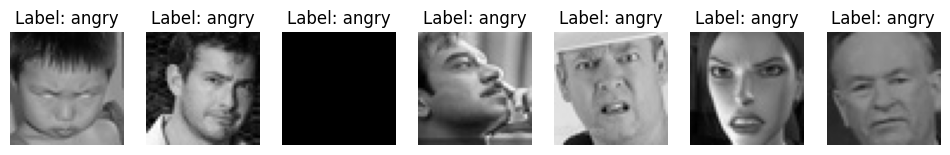

In [12]:
def show_samples(dataset, num_samples=7):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        image, label = dataset[i]
        image = transforms.ToPILImage()(image)  
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.title(f"Label: {dataset.classes[label]}")
        plt.axis('off')
    plt.show()

show_samples(dataset)

Skipping blank image at index 3


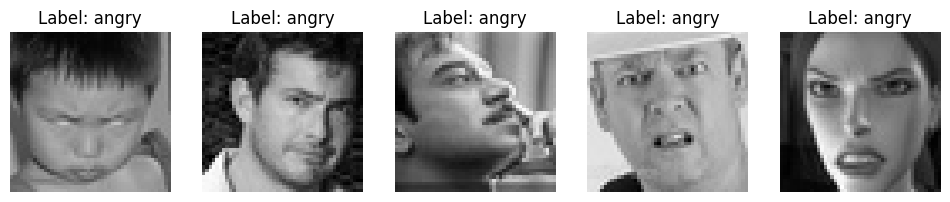

In [17]:
def show_samples(dataset, num_samples=5):
    plt.figure(figsize=(12, 6))
    shown_images = 0
    i = 0

    while shown_images < num_samples and i < len(dataset):
        try:
            image, label = dataset[i]
            i += 1
            image = transforms.ToPILImage()(image)
            if np.array(image).sum() == 0:
                print(f"Skipping blank image at index {i}")
                continue

            plt.subplot(1, num_samples, shown_images + 1)
            plt.imshow(image)
            plt.title(f"Label: {dataset.classes[label]}")
            plt.axis('off')
            shown_images += 1

        except Exception as e:
            print(f"Error loading image at index {i}: {e}")
            continue

    plt.show()

show_samples(dataset)


# sample images in each class

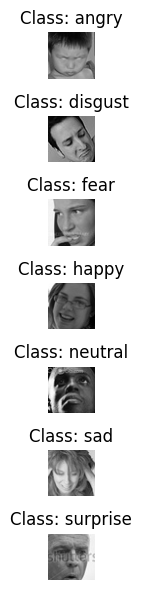

In [16]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def show_samples_per_class(dataset, num_samples_per_class=1):
    class_samples = {class_name: [] for class_name in dataset.classes}  
    
    for image, label in dataset:
        class_name = dataset.classes[label]
        if len(class_samples[class_name]) < num_samples_per_class:
            class_samples[class_name].append((image, label))
        
        if all(len(samples) >= num_samples_per_class for samples in class_samples.values()):
            break

    total_classes = len(dataset.classes)
    plt.figure(figsize=(6, 6))  

    for i, (class_name, samples) in enumerate(class_samples.items()):
        for j, (image, label) in enumerate(samples):
            image = transforms.ToPILImage()(image)
            plt.subplot(total_classes, num_samples_per_class, i * num_samples_per_class + j + 1)
            plt.imshow(image)
            plt.title(f"Class: {class_name}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

show_samples_per_class(dataset)


# No. of images

In [18]:
dataset_path1 = "C:/Users/Abdul/Untitled Folder/Emotion_Detection_Project/data/train"
dataset_path2 = "C:/Users/Abdul/Untitled Folder/Emotion_Detection_Project/data/test"

transform = transforms.Compose([transforms.Grayscale(),transforms.ToTensor()])

dataset1 = datasets.ImageFolder(root=dataset_path1,transform=transform)
dataset2 = datasets.ImageFolder(root=dataset_path2,transform=transform)

print(f"Total images in train dataset : {len(dataset1)}")

print(f"Total images in test dataset : {len(dataset2)}")

Total images in train dataset : 28709
Total images in test dataset : 7178


In [19]:
total = len(dataset1) + len(dataset2)

print(f"(Total no. of images : {total})")

(Total no. of images : 35887)


In [20]:
loader = DataLoader(dataset1,batch_size=64,shuffle=True)
def get_dataset_stats(dataset):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        batch_samples = images.size(0)  
        images = images.view(batch_samples, images.size(1), -1) 
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count
    return mean, std

mean, std = get_dataset_stats(dataset1)


In [22]:
print(f"Mean: {mean}, STD:{std}")

Mean: tensor([0.5077]), STD:tensor([0.2120])


# Class distribution

Class distribution before Balancing
Class Angry : 3995
Class Disgust : 436
Class Fear : 4097
Class Happy : 7215
Class Sad : 4965
Class Surprise : 4830
Class Neutral : 3171


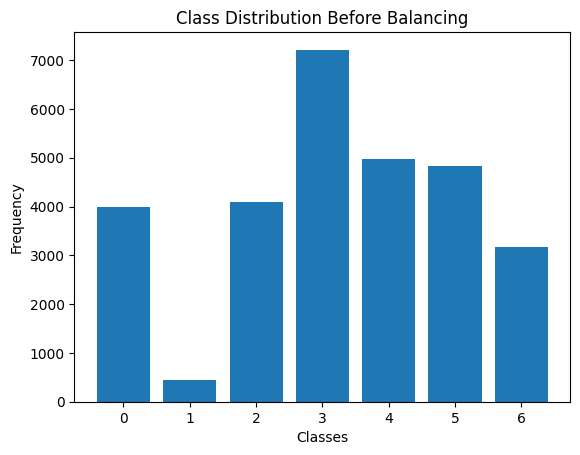

In [24]:
transform1 = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                                ])

train_dataset1 = datasets.ImageFolder(root="C:/Users/Abdul/Untitled Folder/Emotion_Detection_Project/data/train",transform=transform1)
test_dataset1 = datasets.ImageFolder(root="C:/Users/Abdul/Untitled Folder/Emotion_Detection_Project/data/test",transform=transform1)


train_labels = [label for _, label in train_dataset1]
class_counts = Counter(train_labels)

class_mapping = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}


print("Class distribution before Balancing")
for class_label, count in class_counts.items():
    class_name = class_mapping[class_label]  
    print(f'Class {class_name} : {count}')

plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution Before Balancing')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

# Class distribution after balancing

Class distribution after Balancing:
Class Sad : 4176
Class Disgust : 4015
Class Angry : 4106
Class Happy : 4154
Class Surprise : 4124
Class Fear : 4024
Class Neutral : 4110


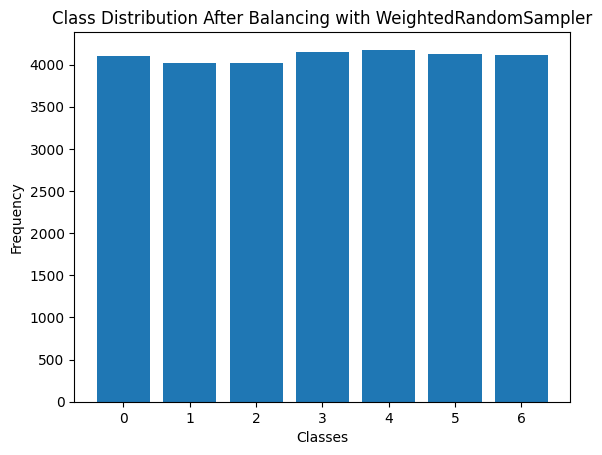

In [25]:
class_weights = 1. / np.array([class_counts[i] for i in range(len(class_counts))])
sample_weights = [class_weights[label] for _, label in train_dataset1]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader1 = DataLoader(train_dataset1, sampler=sampler, batch_size=64)

sampled_labels = []
for data, label in train_loader1:
    sampled_labels.extend(label.tolist())

balanced_class_counts = Counter(sampled_labels)

print("Class distribution after Balancing:")
for class_label, count in balanced_class_counts.items():
    class_name = class_mapping[class_label]  
    print(f'Class {class_name} : {count}')

plt.bar(balanced_class_counts.keys(), balanced_class_counts.values())
plt.title('Class Distribution After Balancing with WeightedRandomSampler')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()


# Cuda availability

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# ResNet18 model

In [29]:
train_loader1 = DataLoader(train_dataset1,sampler=sampler, batch_size=64)
test_loader1 = DataLoader(test_dataset1,batch_size=64,shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(pretrained=True)
model.to(device)  

for param in model.parameters():
    param.requires_grad=False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features,7)
model.fc.to(device)

for param in model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(),lr=0.001)
num_epochs = 20

train_loss = []
test_loss = []
test_accuracy = []

for i in range(num_epochs):  # Ensure num_epochs is defined
    model.train()  # Set model to training mode
    running_loss = 0.0

    with tqdm(total=len(train_loader1), desc=f'Epoch {i + 1}/{num_epochs}', unit='batch') as pbar:
        for inputs, targets in train_loader1:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()  # Accumulate loss
            pbar.set_postfix({'Loss': loss.item()})  # Update progress bar
            pbar.update(1)  # Update pbar

        avg_train_loss = running_loss / len(train_loader1)
        print(f'Epoch {i + 1}/{num_epochs} Training Loss: {avg_train_loss:.4f}')

        # Save the model every 2 epochs
        if (i + 1) % 2 == 0:
            torch.save(model.state_dict(), f"models/resnet18_epoch{i + 1}.pth")

    # Evaluation mode
    model.eval()
    total = 0
    correct = 0
    running_test_loss = 0.0

    with tqdm(total=len(test_loader1), desc='Evaluating', unit='batch') as pbar:
        with torch.no_grad():  # Disable gradient calculation
            for inputs, targets in test_loader1:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, targets)  # Compute loss
                _, predictions = torch.max(outputs.data, 1)  # Get predictions
                total += targets.size(0)
                correct += (predictions == targets).sum().item()
                running_test_loss += loss.item()

                pbar.update(1)  # Update pbar

    avg_test_loss = running_test_loss / len(test_loader1)
    accuracy = correct / total
    print(f'Epoch {i + 1}/{num_epochs} Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    # Append metrics to lists
    train_loss.append(avg_train_loss)
    test_loss.append(avg_test_loss)
    test_accuracy.append(accuracy)

# Save the final model
torch.save(model.state_dict(), "models/resnet18.pth")


c:\Users\Abdul\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Abdul\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/20: 100%|██████████| 449/449 [04:07<00:00,  1.81batch/s, Loss=1.8] 


Epoch 1/20 Training Loss: 1.7409


Evaluating: 100%|██████████| 113/113 [01:41<00:00,  1.11batch/s]


Epoch 1/20 Test Loss: 1.6406, Test Accuracy: 0.3624


Epoch 2/20: 100%|██████████| 449/449 [03:44<00:00,  2.00batch/s, Loss=1.69]


Epoch 2/20 Training Loss: 1.6237


Evaluating: 100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch 2/20 Test Loss: 1.6194, Test Accuracy: 0.3702


Epoch 3/20: 100%|██████████| 449/449 [03:21<00:00,  2.23batch/s, Loss=1.58]


Epoch 3/20 Training Loss: 1.5913


Evaluating: 100%|██████████| 113/113 [00:41<00:00,  2.72batch/s]


Epoch 3/20 Test Loss: 1.6013, Test Accuracy: 0.3943


Epoch 4/20: 100%|██████████| 449/449 [03:08<00:00,  2.39batch/s, Loss=1.8] 


Epoch 4/20 Training Loss: 1.5886


Evaluating: 100%|██████████| 113/113 [00:41<00:00,  2.69batch/s]


Epoch 4/20 Test Loss: 1.5713, Test Accuracy: 0.3963


Epoch 5/20: 100%|██████████| 449/449 [02:58<00:00,  2.51batch/s, Loss=1.5] 


Epoch 5/20 Training Loss: 1.5802


Evaluating: 100%|██████████| 113/113 [00:41<00:00,  2.70batch/s]


Epoch 5/20 Test Loss: 1.5839, Test Accuracy: 0.3904


Epoch 6/20: 100%|██████████| 449/449 [02:56<00:00,  2.55batch/s, Loss=1.65]


Epoch 6/20 Training Loss: 1.5699


Evaluating: 100%|██████████| 113/113 [00:41<00:00,  2.73batch/s]


Epoch 6/20 Test Loss: 1.5878, Test Accuracy: 0.3908


Epoch 7/20: 100%|██████████| 449/449 [02:54<00:00,  2.58batch/s, Loss=1.42]


Epoch 7/20 Training Loss: 1.5651


Evaluating: 100%|██████████| 113/113 [00:40<00:00,  2.76batch/s]


Epoch 7/20 Test Loss: 1.6336, Test Accuracy: 0.3792


Epoch 8/20: 100%|██████████| 449/449 [02:53<00:00,  2.59batch/s, Loss=1.52]


Epoch 8/20 Training Loss: 1.5506


Evaluating: 100%|██████████| 113/113 [00:41<00:00,  2.72batch/s]


Epoch 8/20 Test Loss: 1.5578, Test Accuracy: 0.4065


Epoch 9/20: 100%|██████████| 449/449 [02:52<00:00,  2.61batch/s, Loss=1.7] 


Epoch 9/20 Training Loss: 1.5498


Evaluating: 100%|██████████| 113/113 [00:40<00:00,  2.76batch/s]


Epoch 9/20 Test Loss: 1.5626, Test Accuracy: 0.4001


Epoch 10/20: 100%|██████████| 449/449 [02:54<00:00,  2.57batch/s, Loss=1.43]


Epoch 10/20 Training Loss: 1.5613


Evaluating: 100%|██████████| 113/113 [00:41<00:00,  2.72batch/s]


Epoch 10/20 Test Loss: 1.7139, Test Accuracy: 0.3463


Epoch 11/20: 100%|██████████| 449/449 [02:51<00:00,  2.61batch/s, Loss=1.39]


Epoch 11/20 Training Loss: 1.5610


Evaluating: 100%|██████████| 113/113 [00:41<00:00,  2.73batch/s]


Epoch 11/20 Test Loss: 1.5430, Test Accuracy: 0.4259


Epoch 12/20: 100%|██████████| 449/449 [02:51<00:00,  2.61batch/s, Loss=1.59]


Epoch 12/20 Training Loss: 1.5361


Evaluating: 100%|██████████| 113/113 [00:41<00:00,  2.74batch/s]


Epoch 12/20 Test Loss: 1.6807, Test Accuracy: 0.3566


Epoch 13/20: 100%|██████████| 449/449 [02:51<00:00,  2.62batch/s, Loss=1.4] 


Epoch 13/20 Training Loss: 1.5422


Evaluating: 100%|██████████| 113/113 [00:40<00:00,  2.76batch/s]


Epoch 13/20 Test Loss: 1.5649, Test Accuracy: 0.4096


Epoch 14/20: 100%|██████████| 449/449 [02:50<00:00,  2.63batch/s, Loss=1.19]


Epoch 14/20 Training Loss: 1.5395


Evaluating: 100%|██████████| 113/113 [00:41<00:00,  2.76batch/s]


Epoch 14/20 Test Loss: 1.6334, Test Accuracy: 0.3725


Epoch 15/20: 100%|██████████| 449/449 [02:50<00:00,  2.64batch/s, Loss=1.6] 


Epoch 15/20 Training Loss: 1.5429


Evaluating: 100%|██████████| 113/113 [00:40<00:00,  2.76batch/s]


Epoch 15/20 Test Loss: 1.5305, Test Accuracy: 0.4135


Epoch 16/20: 100%|██████████| 449/449 [02:51<00:00,  2.62batch/s, Loss=1.29]


Epoch 16/20 Training Loss: 1.5362


Evaluating: 100%|██████████| 113/113 [00:41<00:00,  2.74batch/s]


Epoch 16/20 Test Loss: 1.5595, Test Accuracy: 0.4097


Epoch 17/20: 100%|██████████| 449/449 [02:51<00:00,  2.62batch/s, Loss=1.42]


Epoch 17/20 Training Loss: 1.5472


Evaluating: 100%|██████████| 113/113 [00:40<00:00,  2.76batch/s]


Epoch 17/20 Test Loss: 1.5435, Test Accuracy: 0.4157


Epoch 18/20: 100%|██████████| 449/449 [02:53<00:00,  2.59batch/s, Loss=1.73]


Epoch 18/20 Training Loss: 1.5384


Evaluating: 100%|██████████| 113/113 [00:41<00:00,  2.73batch/s]


Epoch 18/20 Test Loss: 1.6523, Test Accuracy: 0.3735


Epoch 19/20: 100%|██████████| 449/449 [02:51<00:00,  2.61batch/s, Loss=1.76]


Epoch 19/20 Training Loss: 1.5300


Evaluating: 100%|██████████| 113/113 [00:41<00:00,  2.75batch/s]


Epoch 19/20 Test Loss: 1.5600, Test Accuracy: 0.4138


Epoch 20/20: 100%|██████████| 449/449 [02:52<00:00,  2.61batch/s, Loss=1.85]


Epoch 20/20 Training Loss: 1.5366


Evaluating: 100%|██████████| 113/113 [00:41<00:00,  2.72batch/s]

Epoch 20/20 Test Loss: 1.5957, Test Accuracy: 0.3922


In [30]:
model.load_state_dict(torch.load('models/resnet18_epoch20.pth'))

optimizer = optim.Adam(model.fc.parameters(),lr=0.001)
num_epochs = 40

for i in range(20,num_epochs):  # Ensure num_epochs is defined
    model.train()  # Set model to training mode
    running_loss = 0.0

    with tqdm(total=len(train_loader1), desc=f'Epoch {i + 1}/{num_epochs}', unit='batch') as pbar:
        for inputs, targets in train_loader1:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()  # Accumulate loss
            pbar.set_postfix({'Loss': loss.item()})  # Update progress bar
            pbar.update(1)  # Update pbar

        avg_train_loss = running_loss / len(train_loader1)
        print(f'Epoch {i + 1}/{num_epochs} Training Loss: {avg_train_loss:.4f}')

        # Save the model every 2 epochs
        if (i + 1) % 2 == 0:
            torch.save(model.state_dict(), f"models/resnet18_epoch{i + 1}.pth")

    # Evaluation mode
    model.eval()
    total = 0
    correct = 0
    running_test_loss = 0.0

    with tqdm(total=len(test_loader1), desc='Evaluating', unit='batch') as pbar:
        with torch.no_grad():  # Disable gradient calculation
            for inputs, targets in test_loader1:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, targets)  # Compute loss
                _, predictions = torch.max(outputs.data, 1)  # Get predictions
                total += targets.size(0)
                correct += (predictions == targets).sum().item()
                running_test_loss += loss.item()

                pbar.update(1)  # Update pbar

    avg_test_loss = running_test_loss / len(test_loader1)
    accuracy = correct / total
    print(f'Epoch {i + 1}/{num_epochs} Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    # Append metrics to lists
    train_loss.append(avg_train_loss)
    test_loss.append(avg_test_loss)
    test_accuracy.append(accuracy)

# Save the final model
torch.save(model.state_dict(), "models/model_resnet18.pth")


C:\Users\Abdul\AppData\Local\Temp\ipykernel_46312\831754695.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/resnet18_epoch20.pth

Epoch 21/40 Training Loss: 1.5409


Evaluating: 100%|██████████| 113/113 [02:12<00:00,  1.17s/batch]


Epoch 21/40 Test Loss: 1.6027, Test Accuracy: 0.3898


Epoch 22/40: 100%|██████████| 449/449 [05:50<00:00,  1.45batch/s, Loss=1.71]

Epoch 22/40 Training Loss: 1.5352


Evaluating: 100%|██████████| 113/113 [01:31<00:00,  1.23batch/s]


Epoch 22/40 Test Loss: 1.6767, Test Accuracy: 0.3636


Epoch 23/40: 100%|██████████| 449/449 [05:41<00:00,  1.31batch/s, Loss=1.66]


Epoch 23/40 Training Loss: 1.5425


Evaluating: 100%|██████████| 113/113 [01:18<00:00,  1.44batch/s]


Epoch 23/40 Test Loss: 1.5975, Test Accuracy: 0.3936


Epoch 24/40: 100%|██████████| 449/449 [03:41<00:00,  2.03batch/s, Loss=1.38]


Epoch 24/40 Training Loss: 1.5363


Evaluating: 100%|██████████| 113/113 [00:41<00:00,  2.72batch/s]


Epoch 24/40 Test Loss: 1.6441, Test Accuracy: 0.3735


Epoch 25/40: 100%|██████████| 449/449 [04:56<00:00,  1.51batch/s, Loss=1.83]


Epoch 25/40 Training Loss: 1.5306


Evaluating: 100%|██████████| 113/113 [00:58<00:00,  1.93batch/s]


Epoch 25/40 Test Loss: 1.5802, Test Accuracy: 0.3984


Epoch 26/40: 100%|██████████| 449/449 [03:52<00:00,  1.93batch/s, Loss=1.47]


Epoch 26/40 Training Loss: 1.5280


Evaluating: 100%|██████████| 113/113 [00:41<00:00,  2.70batch/s]


Epoch 26/40 Test Loss: 1.5466, Test Accuracy: 0.4139


Epoch 27/40: 100%|██████████| 449/449 [03:45<00:00,  1.99batch/s, Loss=1.37]


Epoch 27/40 Training Loss: 1.5291


Evaluating: 100%|██████████| 113/113 [01:32<00:00,  1.22batch/s]


Epoch 27/40 Test Loss: 1.5717, Test Accuracy: 0.3963


Epoch 28/40: 100%|██████████| 449/449 [04:34<00:00,  1.64batch/s, Loss=1.41]


Epoch 28/40 Training Loss: 1.5320


Evaluating: 100%|██████████| 113/113 [00:40<00:00,  2.80batch/s]


Epoch 28/40 Test Loss: 1.5701, Test Accuracy: 0.4061


Epoch 29/40: 100%|██████████| 449/449 [03:33<00:00,  2.10batch/s, Loss=1.77]


Epoch 29/40 Training Loss: 1.5315


Evaluating: 100%|██████████| 113/113 [00:40<00:00,  2.78batch/s]


Epoch 29/40 Test Loss: 1.5542, Test Accuracy: 0.4030


Epoch 30/40: 100%|██████████| 449/449 [03:13<00:00,  2.32batch/s, Loss=1.38]


Epoch 30/40 Training Loss: 1.5308


Evaluating: 100%|██████████| 113/113 [00:40<00:00,  2.77batch/s]


Epoch 30/40 Test Loss: 1.5802, Test Accuracy: 0.3982


Epoch 31/40: 100%|██████████| 449/449 [02:57<00:00,  2.52batch/s, Loss=1.54]


Epoch 31/40 Training Loss: 1.5345


Evaluating: 100%|██████████| 113/113 [00:40<00:00,  2.80batch/s]


Epoch 31/40 Test Loss: 1.5793, Test Accuracy: 0.3911


Epoch 32/40: 100%|██████████| 449/449 [02:58<00:00,  2.51batch/s, Loss=1.44]


Epoch 32/40 Training Loss: 1.5376


Evaluating: 100%|██████████| 113/113 [00:44<00:00,  2.52batch/s]


Epoch 32/40 Test Loss: 1.6007, Test Accuracy: 0.4046


Epoch 33/40: 100%|██████████| 449/449 [03:01<00:00,  2.47batch/s, Loss=1.48]


Epoch 33/40 Training Loss: 1.5294


Evaluating: 100%|██████████| 113/113 [00:43<00:00,  2.63batch/s]


Epoch 33/40 Test Loss: 1.5391, Test Accuracy: 0.4083


Epoch 34/40: 100%|██████████| 449/449 [02:53<00:00,  2.59batch/s, Loss=1.62]


Epoch 34/40 Training Loss: 1.5381


Evaluating: 100%|██████████| 113/113 [00:39<00:00,  2.84batch/s]


Epoch 34/40 Test Loss: 1.5103, Test Accuracy: 0.4209


Epoch 35/40: 100%|██████████| 449/449 [02:47<00:00,  2.68batch/s, Loss=1.49]


Epoch 35/40 Training Loss: 1.5338


Evaluating: 100%|██████████| 113/113 [00:39<00:00,  2.85batch/s]


Epoch 35/40 Test Loss: 1.5436, Test Accuracy: 0.4097


Epoch 36/40: 100%|██████████| 449/449 [02:46<00:00,  2.70batch/s, Loss=1.54]


Epoch 36/40 Training Loss: 1.5307


Evaluating: 100%|██████████| 113/113 [00:39<00:00,  2.85batch/s]


Epoch 36/40 Test Loss: 1.6021, Test Accuracy: 0.3905


Epoch 37/40: 100%|██████████| 449/449 [02:45<00:00,  2.71batch/s, Loss=1.52]


Epoch 37/40 Training Loss: 1.5313


Evaluating: 100%|██████████| 113/113 [00:39<00:00,  2.86batch/s]


Epoch 37/40 Test Loss: 1.5844, Test Accuracy: 0.4111


Epoch 38/40: 100%|██████████| 449/449 [02:48<00:00,  2.66batch/s, Loss=1.23]


Epoch 38/40 Training Loss: 1.5258


Evaluating: 100%|██████████| 113/113 [00:42<00:00,  2.65batch/s]


Epoch 38/40 Test Loss: 1.5835, Test Accuracy: 0.3950


Epoch 39/40: 100%|██████████| 449/449 [02:59<00:00,  2.50batch/s, Loss=1.66]


Epoch 39/40 Training Loss: 1.5276


Evaluating: 100%|██████████| 113/113 [00:40<00:00,  2.78batch/s]


Epoch 39/40 Test Loss: 1.5254, Test Accuracy: 0.4203


Epoch 40/40: 100%|██████████| 449/449 [02:51<00:00,  2.61batch/s, Loss=1.54]


Epoch 40/40 Training Loss: 1.5338


Evaluating: 100%|██████████| 113/113 [00:40<00:00,  2.77batch/s]

Epoch 40/40 Test Loss: 1.6023, Test Accuracy: 0.3877


In [31]:
import pandas as pd

df = pd.DataFrame({
    "epoch": range(1, num_epochs + 1),
    "train_loss": train_loss,
    "test_loss": test_loss,
    "test_accuracy": test_accuracy
})

df.to_csv("resnet18_training_metrics.csv", index=False)

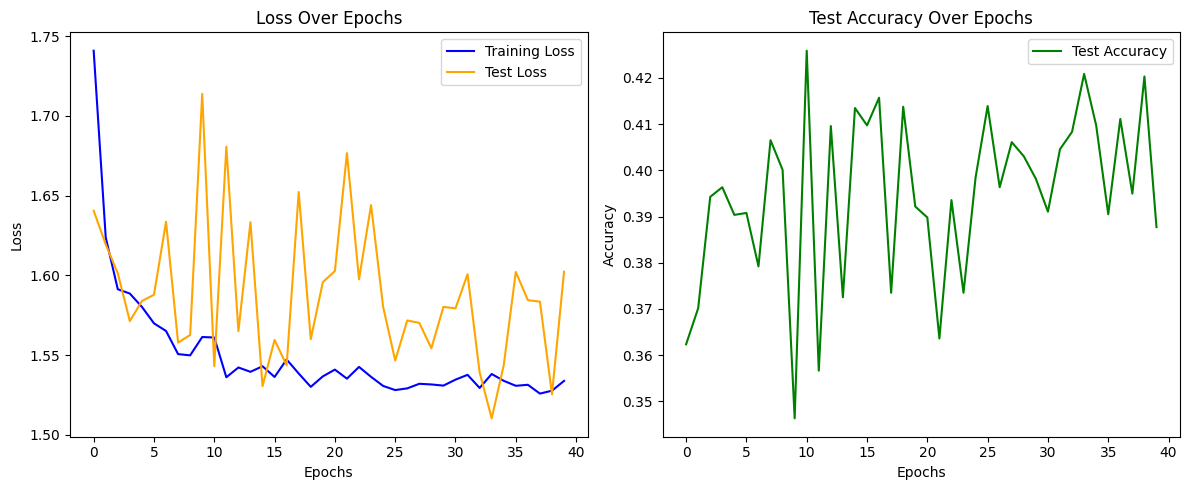

In [32]:
loaded_df = pd.read_csv("resnet18_training_metrics.csv")
train_loss = loaded_df["train_loss"].tolist()
test_loss = loaded_df["test_loss"].tolist()
test_accuracy = loaded_df["test_accuracy"].tolist()


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Test Loss', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracy, label='Test Accuracy', color='green')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# GoogleNet model

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.googlenet(pretrained=True)
model.to(device)  

for param in model.parameters():
    param.requires_grad=False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features,7)
model.fc.to(device)

for param in model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(),lr=0.001)
num_epochs = 40

train_loss1 = []
test_loss1 = []
test_accuracy1 = []

for i in range(num_epochs):  # Ensure num_epochs is defined
    model.train()  # Set model to training mode
    running_loss = 0.0

    with tqdm(total=len(train_loader1), desc=f'Epoch {i + 1}/{num_epochs}', unit='batch') as pbar:
        for inputs, targets in train_loader1:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()  # Accumulate loss
            pbar.set_postfix({'Loss': loss.item()})  # Update progress bar
            pbar.update(1)  # Update pbar

        avg_train_loss = running_loss / len(train_loader1)
        print(f'Epoch {i + 1}/{num_epochs} Training Loss: {avg_train_loss:.4f}')

        # Save the model every 2 epochs
        if (i + 1) % 2 == 0:
            torch.save(model.state_dict(), f"models/googlenet_epoch{i + 1}.pth")

    # Evaluation mode
    model.eval()
    total = 0
    correct = 0
    running_test_loss = 0.0

    with tqdm(total=len(test_loader1), desc='Evaluating', unit='batch') as pbar:
        with torch.no_grad():  # Disable gradient calculation
            for inputs, targets in test_loader1:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, targets)  # Compute loss
                _, predictions = torch.max(outputs.data, 1)  # Get predictions
                total += targets.size(0)
                correct += (predictions == targets).sum().item()
                running_test_loss += loss.item()

                pbar.update(1)  # Update pbar

    avg_test_loss = running_test_loss / len(test_loader1)
    accuracy = correct / total
    print(f'Epoch {i + 1}/{num_epochs} Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    # Append metrics to lists
    train_loss1.append(avg_train_loss)
    test_loss1.append(avg_test_loss)
    test_accuracy1.append(accuracy)

# Save the final model
torch.save(model.state_dict(), "models/model_googlenet.pth")


c:\Users\Abdul\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Abdul\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/40: 100%|██████████| 449/449 [03:00<00:00,  2.49batch/s, Loss=1.66]


Epoch 1/40 Training Loss: 1.7565


Evaluating: 100%|██████████| 113/113 [00:45<00:00,  2.49batch/s]


Epoch 1/40 Test Loss: 1.6747, Test Accuracy: 0.3541


Epoch 2/40: 100%|██████████| 449/449 [03:10<00:00,  2.36batch/s, Loss=1.77]


Epoch 2/40 Training Loss: 1.6649


Evaluating: 100%|██████████| 113/113 [00:45<00:00,  2.49batch/s]


Epoch 2/40 Test Loss: 1.6502, Test Accuracy: 0.3554


Epoch 3/40: 100%|██████████| 449/449 [03:19<00:00,  2.26batch/s, Loss=1.71]


Epoch 3/40 Training Loss: 1.6423


Evaluating: 100%|██████████| 113/113 [00:48<00:00,  2.35batch/s]


Epoch 3/40 Test Loss: 1.6507, Test Accuracy: 0.3594


Epoch 4/40: 100%|██████████| 449/449 [03:21<00:00,  2.22batch/s, Loss=1.41]


Epoch 4/40 Training Loss: 1.6329


Evaluating: 100%|██████████| 113/113 [00:48<00:00,  2.33batch/s]


Epoch 4/40 Test Loss: 1.6193, Test Accuracy: 0.3794


Epoch 5/40: 100%|██████████| 449/449 [03:21<00:00,  2.22batch/s, Loss=1.65]


Epoch 5/40 Training Loss: 1.6248


Evaluating: 100%|██████████| 113/113 [00:48<00:00,  2.35batch/s]


Epoch 5/40 Test Loss: 1.5965, Test Accuracy: 0.3859


Epoch 6/40: 100%|██████████| 449/449 [03:22<00:00,  2.22batch/s, Loss=1.44]


Epoch 6/40 Training Loss: 1.6309


Evaluating: 100%|██████████| 113/113 [00:48<00:00,  2.35batch/s]


Epoch 6/40 Test Loss: 1.6158, Test Accuracy: 0.3812


Epoch 7/40: 100%|██████████| 449/449 [03:21<00:00,  2.23batch/s, Loss=1.63]


Epoch 7/40 Training Loss: 1.6237


Evaluating: 100%|██████████| 113/113 [00:49<00:00,  2.28batch/s]


Epoch 7/40 Test Loss: 1.6137, Test Accuracy: 0.3735


Epoch 8/40: 100%|██████████| 449/449 [03:20<00:00,  2.23batch/s, Loss=1.49]


Epoch 8/40 Training Loss: 1.6180


Evaluating: 100%|██████████| 113/113 [00:48<00:00,  2.35batch/s]


Epoch 8/40 Test Loss: 1.6136, Test Accuracy: 0.3810


Epoch 9/40: 100%|██████████| 449/449 [03:21<00:00,  2.23batch/s, Loss=1.82]


Epoch 9/40 Training Loss: 1.6228


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.37batch/s]


Epoch 9/40 Test Loss: 1.5680, Test Accuracy: 0.4154


Epoch 10/40: 100%|██████████| 449/449 [04:04<00:00,  1.83batch/s, Loss=1.34]


Epoch 10/40 Training Loss: 1.6109


Evaluating: 100%|██████████| 113/113 [01:38<00:00,  1.15batch/s]


Epoch 10/40 Test Loss: 1.6318, Test Accuracy: 0.3729


Epoch 11/40: 100%|██████████| 449/449 [04:56<00:00,  1.52batch/s, Loss=1.52]


Epoch 11/40 Training Loss: 1.6193


Evaluating: 100%|██████████| 113/113 [00:54<00:00,  2.07batch/s]


Epoch 11/40 Test Loss: 1.6710, Test Accuracy: 0.3417


Epoch 12/40: 100%|██████████| 449/449 [04:13<00:00,  1.77batch/s, Loss=1.46]


Epoch 12/40 Training Loss: 1.6267


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.36batch/s]


Epoch 12/40 Test Loss: 1.5923, Test Accuracy: 0.3870


Epoch 13/40: 100%|██████████| 449/449 [03:38<00:00,  2.05batch/s, Loss=1.48]


Epoch 13/40 Training Loss: 1.6194


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.37batch/s]


Epoch 13/40 Test Loss: 1.5821, Test Accuracy: 0.3940


Epoch 14/40: 100%|██████████| 449/449 [03:28<00:00,  2.15batch/s, Loss=1.76]


Epoch 14/40 Training Loss: 1.6244


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.36batch/s]


Epoch 14/40 Test Loss: 1.5857, Test Accuracy: 0.3941


Epoch 15/40: 100%|██████████| 449/449 [03:24<00:00,  2.19batch/s, Loss=1.57]


Epoch 15/40 Training Loss: 1.6124


Evaluating: 100%|██████████| 113/113 [00:48<00:00,  2.34batch/s]


Epoch 15/40 Test Loss: 1.6643, Test Accuracy: 0.3562


Epoch 16/40: 100%|██████████| 449/449 [03:22<00:00,  2.21batch/s, Loss=1.56]


Epoch 16/40 Training Loss: 1.6232


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.37batch/s]


Epoch 16/40 Test Loss: 1.5642, Test Accuracy: 0.4033


Epoch 17/40: 100%|██████████| 449/449 [03:21<00:00,  2.22batch/s, Loss=1.54]


Epoch 17/40 Training Loss: 1.6254


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.37batch/s]


Epoch 17/40 Test Loss: 1.6155, Test Accuracy: 0.3690


Epoch 18/40: 100%|██████████| 449/449 [03:21<00:00,  2.23batch/s, Loss=1.62]


Epoch 18/40 Training Loss: 1.6162


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.37batch/s]


Epoch 18/40 Test Loss: 1.5840, Test Accuracy: 0.3911


Epoch 19/40: 100%|██████████| 449/449 [03:20<00:00,  2.24batch/s, Loss=1.8] 


Epoch 19/40 Training Loss: 1.6129


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.38batch/s]


Epoch 19/40 Test Loss: 1.6050, Test Accuracy: 0.3771


Epoch 20/40: 100%|██████████| 449/449 [03:20<00:00,  2.24batch/s, Loss=1.41]


Epoch 20/40 Training Loss: 1.6151


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.37batch/s]


Epoch 20/40 Test Loss: 1.5881, Test Accuracy: 0.3873


Epoch 21/40: 100%|██████████| 449/449 [03:20<00:00,  2.24batch/s, Loss=1.63]


Epoch 21/40 Training Loss: 1.6318


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.36batch/s]


Epoch 21/40 Test Loss: 1.5818, Test Accuracy: 0.3924


Epoch 22/40: 100%|██████████| 449/449 [03:20<00:00,  2.24batch/s, Loss=1.3] 


Epoch 22/40 Training Loss: 1.6146


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.36batch/s]


Epoch 22/40 Test Loss: 1.5851, Test Accuracy: 0.3936


Epoch 23/40: 100%|██████████| 449/449 [03:20<00:00,  2.24batch/s, Loss=1.9] 


Epoch 23/40 Training Loss: 1.6119


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.37batch/s]


Epoch 23/40 Test Loss: 1.6082, Test Accuracy: 0.3794


Epoch 24/40: 100%|██████████| 449/449 [03:20<00:00,  2.24batch/s, Loss=1.68]


Epoch 24/40 Training Loss: 1.6283


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.37batch/s]


Epoch 24/40 Test Loss: 1.5959, Test Accuracy: 0.3884


Epoch 25/40: 100%|██████████| 449/449 [03:20<00:00,  2.24batch/s, Loss=1.59]


Epoch 25/40 Training Loss: 1.6228


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.37batch/s]


Epoch 25/40 Test Loss: 1.6728, Test Accuracy: 0.3452


Epoch 26/40: 100%|██████████| 449/449 [03:20<00:00,  2.24batch/s, Loss=1.85]


Epoch 26/40 Training Loss: 1.6201


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.36batch/s]


Epoch 26/40 Test Loss: 1.5954, Test Accuracy: 0.3933


Epoch 27/40: 100%|██████████| 449/449 [03:20<00:00,  2.24batch/s, Loss=1.53]


Epoch 27/40 Training Loss: 1.6221


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.37batch/s]


Epoch 27/40 Test Loss: 1.5799, Test Accuracy: 0.3970


Epoch 28/40: 100%|██████████| 449/449 [03:20<00:00,  2.24batch/s, Loss=1.53]


Epoch 28/40 Training Loss: 1.6280


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.36batch/s]


Epoch 28/40 Test Loss: 1.5726, Test Accuracy: 0.3986


Epoch 29/40: 100%|██████████| 449/449 [03:21<00:00,  2.23batch/s, Loss=1.77]


Epoch 29/40 Training Loss: 1.6139


Evaluating: 100%|██████████| 113/113 [00:48<00:00,  2.35batch/s]


Epoch 29/40 Test Loss: 1.6256, Test Accuracy: 0.3774


Epoch 30/40: 100%|██████████| 449/449 [03:22<00:00,  2.22batch/s, Loss=1.57]


Epoch 30/40 Training Loss: 1.6242


Evaluating: 100%|██████████| 113/113 [00:48<00:00,  2.34batch/s]


Epoch 30/40 Test Loss: 1.6214, Test Accuracy: 0.3813


Epoch 31/40: 100%|██████████| 449/449 [03:21<00:00,  2.23batch/s, Loss=1.56]


Epoch 31/40 Training Loss: 1.6211


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.36batch/s]


Epoch 31/40 Test Loss: 1.5753, Test Accuracy: 0.4021


Epoch 32/40: 100%|██████████| 449/449 [03:22<00:00,  2.21batch/s, Loss=1.89]


Epoch 32/40 Training Loss: 1.6220


Evaluating: 100%|██████████| 113/113 [00:48<00:00,  2.35batch/s]


Epoch 32/40 Test Loss: 1.6163, Test Accuracy: 0.3773


Epoch 33/40: 100%|██████████| 449/449 [03:21<00:00,  2.22batch/s, Loss=1.74]


Epoch 33/40 Training Loss: 1.6212


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.36batch/s]


Epoch 33/40 Test Loss: 1.5689, Test Accuracy: 0.3970


Epoch 34/40: 100%|██████████| 449/449 [03:21<00:00,  2.23batch/s, Loss=1.43]


Epoch 34/40 Training Loss: 1.6151


Evaluating: 100%|██████████| 113/113 [00:48<00:00,  2.35batch/s]


Epoch 34/40 Test Loss: 1.5576, Test Accuracy: 0.3934


Epoch 35/40: 100%|██████████| 449/449 [03:21<00:00,  2.23batch/s, Loss=1.69]


Epoch 35/40 Training Loss: 1.6101


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.36batch/s]


Epoch 35/40 Test Loss: 1.5408, Test Accuracy: 0.4171


Epoch 36/40: 100%|██████████| 449/449 [03:21<00:00,  2.23batch/s, Loss=1.7] 


Epoch 36/40 Training Loss: 1.6218


Evaluating: 100%|██████████| 113/113 [00:48<00:00,  2.34batch/s]


Epoch 36/40 Test Loss: 1.5709, Test Accuracy: 0.4025


Epoch 37/40: 100%|██████████| 449/449 [03:19<00:00,  2.25batch/s, Loss=1.45]


Epoch 37/40 Training Loss: 1.6226


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.39batch/s]


Epoch 37/40 Test Loss: 1.5430, Test Accuracy: 0.4172


Epoch 38/40: 100%|██████████| 449/449 [03:25<00:00,  2.18batch/s, Loss=1.77]


Epoch 38/40 Training Loss: 1.6229


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.38batch/s]


Epoch 38/40 Test Loss: 1.6231, Test Accuracy: 0.3711


Epoch 39/40: 100%|██████████| 449/449 [03:19<00:00,  2.26batch/s, Loss=1.7] 


Epoch 39/40 Training Loss: 1.6060


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.38batch/s]


Epoch 39/40 Test Loss: 1.6080, Test Accuracy: 0.3777


Epoch 40/40: 100%|██████████| 449/449 [03:18<00:00,  2.26batch/s, Loss=1.73]


Epoch 40/40 Training Loss: 1.6212


Evaluating: 100%|██████████| 113/113 [00:47<00:00,  2.39batch/s]

Epoch 40/40 Test Loss: 1.5739, Test Accuracy: 0.3968


In [34]:
import pandas as pd

df1 = pd.DataFrame({
    "epoch": range(1, num_epochs + 1),
    "train_loss": train_loss1,
    "test_loss": test_loss1,
    "test_accuracy": test_accuracy1
})

df1.to_csv("googlenet_training_metrics.csv", index=False)

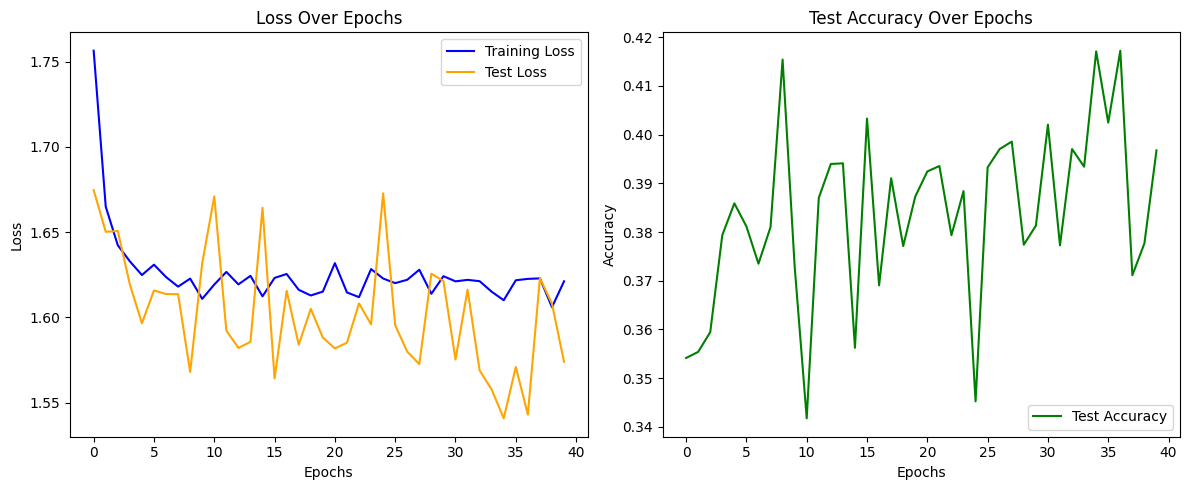

In [35]:
loaded_df1 = pd.read_csv("googlenet_training_metrics.csv")
train_loss1 = loaded_df1["train_loss"].tolist()
test_loss1 = loaded_df1["test_loss"].tolist()
test_accuracy1 = loaded_df1["test_accuracy"].tolist()


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss1, label='Training Loss', color='blue')
plt.plot(test_loss1, label='Test Loss', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracy1, label='Test Accuracy', color='green')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# ShuffleNet V2 model

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.shufflenet_v2_x1_0(pretrained=True)
model.to(device)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 7)  # 7 output classes for FER2013
model.fc.requires_grad = True  # Only the classifier is trainable
model.fc = model.fc.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
num_epochs = 40

train_loss2 = []
test_loss2 = []
test_accuracy2 = []

for i in range(num_epochs):  # Ensure num_epochs is defined
    model.train()  # Set model to training mode
    running_loss = 0.0

    with tqdm(total=len(train_loader1), desc=f'Epoch {i + 1}/{num_epochs}', unit='batch') as pbar:
        for inputs, targets in train_loader1:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()  # Accumulate loss
            pbar.set_postfix({'Loss': loss.item()})  # Update progress bar
            pbar.update(1)  # Update pbar

        avg_train_loss = running_loss / len(train_loader1)
        print(f'Epoch {i + 1}/{num_epochs} Training Loss: {avg_train_loss:.4f}')

        # Save the model every 2 epochs
        if (i + 1) % 2 == 0:
            torch.save(model.state_dict(), f"models/shufflenet_epoch{i + 1}.pth")

    # Evaluation mode
    model.eval()
    total = 0
    correct = 0
    running_test_loss = 0.0

    with tqdm(total=len(test_loader1), desc='Evaluating', unit='batch') as pbar:
        with torch.no_grad():  # Disable gradient calculation
            for inputs, targets in test_loader1:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, targets)  # Compute loss
                _, predictions = torch.max(outputs.data, 1)  # Get predictions
                total += targets.size(0)
                correct += (predictions == targets).sum().item()
                running_test_loss += loss.item()

                pbar.update(1)  # Update pbar

    avg_test_loss = running_test_loss / len(test_loader1)
    accuracy = correct / total
    print(f'Epoch {i + 1}/{num_epochs} Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    # Append metrics to lists
    train_loss2.append(avg_train_loss)
    test_loss2.append(avg_test_loss)
    test_accuracy2.append(accuracy)

# Save the final model
torch.save(model.state_dict(), "models/model_shufflenet.pth")


c:\Users\Abdul\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to C:\Users\Abdul/.cache\torch\hub\checkpoints\shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:02<00:00, 4.01MB/s]
Epoch 1/40: 100%|██████████| 449/449 [08:26<00:00,  1.13s/batch, Loss=1.8] 


Epoch 1/40 Training Loss: 1.8858


Evaluating: 100%|██████████| 113/113 [01:56<00:00,  1.03s/batch]


Epoch 1/40 Test Loss: 1.8354, Test Accuracy: 0.3317


Epoch 2/40: 100%|██████████| 449/449 [08:15<00:00,  1.10s/batch, Loss=1.77]


Epoch 2/40 Training Loss: 1.8040


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.09batch/s]


Epoch 2/40 Test Loss: 1.7737, Test Accuracy: 0.3470


Epoch 3/40: 100%|██████████| 449/449 [07:57<00:00,  1.06s/batch, Loss=1.78]


Epoch 3/40 Training Loss: 1.7503


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.09batch/s]


Epoch 3/40 Test Loss: 1.7564, Test Accuracy: 0.3376


Epoch 4/40: 100%|██████████| 449/449 [07:45<00:00,  1.04s/batch, Loss=1.78]


Epoch 4/40 Training Loss: 1.7145


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.09batch/s]


Epoch 4/40 Test Loss: 1.7147, Test Accuracy: 0.3598


Epoch 5/40: 100%|██████████| 449/449 [07:37<00:00,  1.02s/batch, Loss=1.63]


Epoch 5/40 Training Loss: 1.6931


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.09batch/s]


Epoch 5/40 Test Loss: 1.6991, Test Accuracy: 0.3597


Epoch 6/40: 100%|██████████| 449/449 [08:10<00:00,  1.09s/batch, Loss=1.67]


Epoch 6/40 Training Loss: 1.6735


Evaluating: 100%|██████████| 113/113 [02:44<00:00,  1.46s/batch]


Epoch 6/40 Test Loss: 1.6712, Test Accuracy: 0.3742


Epoch 7/40: 100%|██████████| 449/449 [08:38<00:00,  1.16s/batch, Loss=1.67]


Epoch 7/40 Training Loss: 1.6564


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.09batch/s]


Epoch 7/40 Test Loss: 1.6794, Test Accuracy: 0.3605


Epoch 8/40: 100%|██████████| 449/449 [08:08<00:00,  1.09s/batch, Loss=1.64]


Epoch 8/40 Training Loss: 1.6427


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.09batch/s]


Epoch 8/40 Test Loss: 1.6619, Test Accuracy: 0.3713


Epoch 9/40: 100%|██████████| 449/449 [07:49<00:00,  1.04s/batch, Loss=1.51]


Epoch 9/40 Training Loss: 1.6399


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.10batch/s]


Epoch 9/40 Test Loss: 1.6497, Test Accuracy: 0.3781


Epoch 10/40: 100%|██████████| 449/449 [07:38<00:00,  1.02s/batch, Loss=1.66]


Epoch 10/40 Training Loss: 1.6217


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.10batch/s]


Epoch 10/40 Test Loss: 1.6370, Test Accuracy: 0.3828


Epoch 11/40: 100%|██████████| 449/449 [07:32<00:00,  1.01s/batch, Loss=1.68]


Epoch 11/40 Training Loss: 1.6133


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.10batch/s]


Epoch 11/40 Test Loss: 1.6295, Test Accuracy: 0.3849


Epoch 12/40: 100%|██████████| 449/449 [07:30<00:00,  1.00s/batch, Loss=1.63]


Epoch 12/40 Training Loss: 1.6000


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.09batch/s]


Epoch 12/40 Test Loss: 1.6245, Test Accuracy: 0.3863


Epoch 13/40: 100%|██████████| 449/449 [07:29<00:00,  1.00s/batch, Loss=1.52]


Epoch 13/40 Training Loss: 1.5942


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.09batch/s]


Epoch 13/40 Test Loss: 1.6316, Test Accuracy: 0.3767


Epoch 14/40: 100%|██████████| 449/449 [07:28<00:00,  1.00batch/s, Loss=1.66]


Epoch 14/40 Training Loss: 1.5921


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.09batch/s]


Epoch 14/40 Test Loss: 1.5948, Test Accuracy: 0.4016


Epoch 15/40: 100%|██████████| 449/449 [07:26<00:00,  1.01batch/s, Loss=1.64]


Epoch 15/40 Training Loss: 1.5793


Evaluating: 100%|██████████| 113/113 [01:44<00:00,  1.08batch/s]


Epoch 15/40 Test Loss: 1.6085, Test Accuracy: 0.3894


Epoch 16/40: 100%|██████████| 449/449 [07:51<00:00,  1.05s/batch, Loss=1.57]


Epoch 16/40 Training Loss: 1.5792


Evaluating: 100%|██████████| 113/113 [01:46<00:00,  1.06batch/s]


Epoch 16/40 Test Loss: 1.5880, Test Accuracy: 0.4060


Epoch 17/40: 100%|██████████| 449/449 [07:50<00:00,  1.05s/batch, Loss=1.62]


Epoch 17/40 Training Loss: 1.5688


Evaluating: 100%|██████████| 113/113 [01:46<00:00,  1.06batch/s]


Epoch 17/40 Test Loss: 1.5816, Test Accuracy: 0.4036


Epoch 18/40: 100%|██████████| 449/449 [07:50<00:00,  1.05s/batch, Loss=1.62]


Epoch 18/40 Training Loss: 1.5602


Evaluating: 100%|██████████| 113/113 [01:46<00:00,  1.06batch/s]


Epoch 18/40 Test Loss: 1.5768, Test Accuracy: 0.4115


Epoch 19/40: 100%|██████████| 449/449 [07:51<00:00,  1.05s/batch, Loss=1.6] 


Epoch 19/40 Training Loss: 1.5658


Evaluating: 100%|██████████| 113/113 [01:45<00:00,  1.07batch/s]


Epoch 19/40 Test Loss: 1.5955, Test Accuracy: 0.3947


Epoch 20/40: 100%|██████████| 449/449 [07:50<00:00,  1.05s/batch, Loss=1.58]


Epoch 20/40 Training Loss: 1.5571


Evaluating: 100%|██████████| 113/113 [01:45<00:00,  1.07batch/s]


Epoch 20/40 Test Loss: 1.5744, Test Accuracy: 0.4079


Epoch 21/40: 100%|██████████| 449/449 [07:50<00:00,  1.05s/batch, Loss=1.51]


Epoch 21/40 Training Loss: 1.5551


Evaluating: 100%|██████████| 113/113 [01:46<00:00,  1.06batch/s]


Epoch 21/40 Test Loss: 1.5714, Test Accuracy: 0.4068


Epoch 22/40: 100%|██████████| 449/449 [07:27<00:00,  1.00batch/s, Loss=1.49]


Epoch 22/40 Training Loss: 1.5505


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.09batch/s]


Epoch 22/40 Test Loss: 1.5632, Test Accuracy: 0.4103


Epoch 23/40: 100%|██████████| 449/449 [07:27<00:00,  1.00batch/s, Loss=1.5] 


Epoch 23/40 Training Loss: 1.5429


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.10batch/s]


Epoch 23/40 Test Loss: 1.5561, Test Accuracy: 0.4156


Epoch 24/40: 100%|██████████| 449/449 [07:26<00:00,  1.01batch/s, Loss=1.62]


Epoch 24/40 Training Loss: 1.5333


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.10batch/s]


Epoch 24/40 Test Loss: 1.5532, Test Accuracy: 0.4153


Epoch 25/40: 100%|██████████| 449/449 [07:29<00:00,  1.00s/batch, Loss=1.71]


Epoch 25/40 Training Loss: 1.5456


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.10batch/s]


Epoch 25/40 Test Loss: 1.5517, Test Accuracy: 0.4149


Epoch 26/40: 100%|██████████| 449/449 [07:28<00:00,  1.00batch/s, Loss=1.42]


Epoch 26/40 Training Loss: 1.5433


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.09batch/s]


Epoch 26/40 Test Loss: 1.5596, Test Accuracy: 0.4078


Epoch 27/40: 100%|██████████| 449/449 [07:28<00:00,  1.00batch/s, Loss=1.52]


Epoch 27/40 Training Loss: 1.5267


Evaluating: 100%|██████████| 113/113 [01:42<00:00,  1.10batch/s]


Epoch 27/40 Test Loss: 1.5751, Test Accuracy: 0.4042


Epoch 28/40: 100%|██████████| 449/449 [07:28<00:00,  1.00batch/s, Loss=1.54]


Epoch 28/40 Training Loss: 1.5304


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.09batch/s]


Epoch 28/40 Test Loss: 1.5353, Test Accuracy: 0.4160


Epoch 29/40: 100%|██████████| 449/449 [07:27<00:00,  1.00batch/s, Loss=1.47]


Epoch 29/40 Training Loss: 1.5183


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.09batch/s]


Epoch 29/40 Test Loss: 1.5632, Test Accuracy: 0.4096


Epoch 30/40: 100%|██████████| 449/449 [07:32<00:00,  1.01s/batch, Loss=1.52]


Epoch 30/40 Training Loss: 1.5140


Evaluating: 100%|██████████| 113/113 [01:45<00:00,  1.07batch/s]


Epoch 30/40 Test Loss: 1.5675, Test Accuracy: 0.4079


Epoch 31/40: 100%|██████████| 449/449 [07:33<00:00,  1.01s/batch, Loss=1.8] 


Epoch 31/40 Training Loss: 1.5207


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.09batch/s]


Epoch 31/40 Test Loss: 1.5526, Test Accuracy: 0.4152


Epoch 32/40: 100%|██████████| 449/449 [07:28<00:00,  1.00batch/s, Loss=1.82]


Epoch 32/40 Training Loss: 1.5203


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.09batch/s]


Epoch 32/40 Test Loss: 1.5444, Test Accuracy: 0.4145


Epoch 33/40: 100%|██████████| 449/449 [07:27<00:00,  1.00batch/s, Loss=1.66]


Epoch 33/40 Training Loss: 1.5075


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.09batch/s]


Epoch 33/40 Test Loss: 1.5363, Test Accuracy: 0.4153


Epoch 34/40: 100%|██████████| 449/449 [07:26<00:00,  1.01batch/s, Loss=1.49]


Epoch 34/40 Training Loss: 1.5134


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.09batch/s]


Epoch 34/40 Test Loss: 1.5456, Test Accuracy: 0.4166


Epoch 35/40: 100%|██████████| 449/449 [07:28<00:00,  1.00batch/s, Loss=1.55]


Epoch 35/40 Training Loss: 1.5083


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.09batch/s]


Epoch 35/40 Test Loss: 1.5437, Test Accuracy: 0.4108


Epoch 36/40: 100%|██████████| 449/449 [07:27<00:00,  1.00batch/s, Loss=1.74]


Epoch 36/40 Training Loss: 1.5052


Evaluating: 100%|██████████| 113/113 [01:43<00:00,  1.09batch/s]


Epoch 36/40 Test Loss: 1.5309, Test Accuracy: 0.4207


Epoch 37/40: 100%|██████████| 449/449 [07:30<00:00,  1.00s/batch, Loss=1.32]


Epoch 37/40 Training Loss: 1.5010


Evaluating: 100%|██████████| 113/113 [01:46<00:00,  1.06batch/s]


Epoch 37/40 Test Loss: 1.5354, Test Accuracy: 0.4216


Epoch 38/40: 100%|██████████| 449/449 [08:05<00:00,  1.08s/batch, Loss=1.44]


Epoch 38/40 Training Loss: 1.5059


Evaluating: 100%|██████████| 113/113 [02:03<00:00,  1.10s/batch]


Epoch 38/40 Test Loss: 1.5391, Test Accuracy: 0.4205


Epoch 39/40: 100%|██████████| 449/449 [09:17<00:00,  1.24s/batch, Loss=1.45]


Epoch 39/40 Training Loss: 1.5031


Evaluating: 100%|██████████| 113/113 [02:00<00:00,  1.06s/batch]


Epoch 39/40 Test Loss: 1.5353, Test Accuracy: 0.4188


Epoch 40/40: 100%|██████████| 449/449 [08:41<00:00,  1.16s/batch, Loss=1.59]


Epoch 40/40 Training Loss: 1.4991


Evaluating: 100%|██████████| 113/113 [01:46<00:00,  1.06batch/s]

Epoch 40/40 Test Loss: 1.5211, Test Accuracy: 0.4224


In [40]:
import pandas as pd

df2 = pd.DataFrame({
    "epoch": range(1, num_epochs + 1),
    "train_loss": train_loss2,
    "test_loss": test_loss2,
    "test_accuracy": test_accuracy2
})

df2.to_csv("shufflenet_training_metrics.csv", index=False)

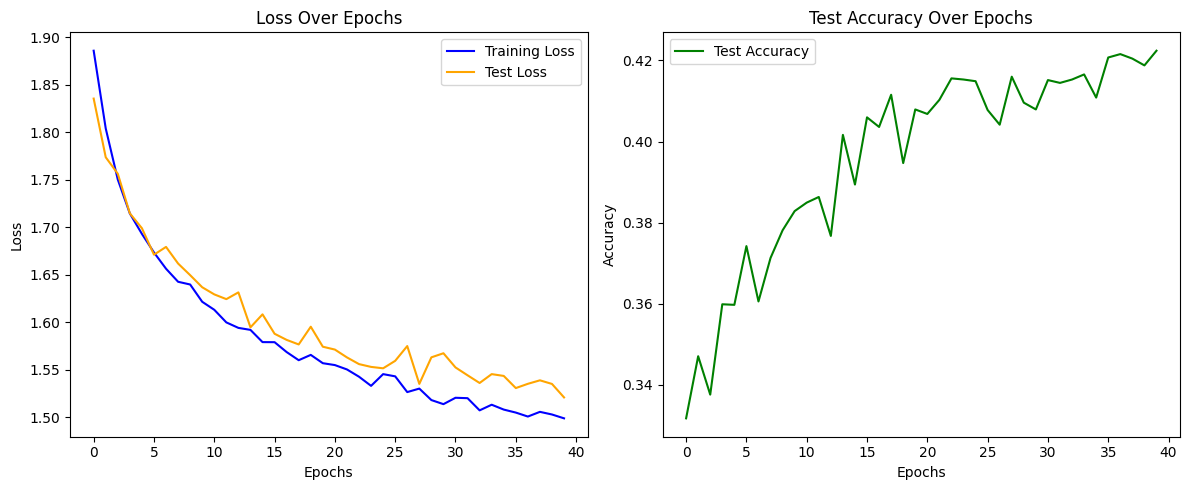

In [42]:
loaded_df2 = pd.read_csv("shufflenet_training_metrics.csv")
train_loss2 = loaded_df2["train_loss"].tolist()
test_loss2 = loaded_df2["test_loss"].tolist()
test_accuracy2 = loaded_df2["test_accuracy"].tolist()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss2, label='Training Loss', color='blue')
plt.plot(test_loss2, label='Test Loss', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracy2, label='Test Accuracy', color='green')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# CNN model

In [4]:
transform2 = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                transforms.Resize((128,128)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                                ])

train_dataset2 = datasets.ImageFolder(root="C:/Users/Abdul/Untitled Folder/Emotion_Detection_Project/data/train",transform=transform2)
test_dataset2 = datasets.ImageFolder(root="C:/Users/Abdul/Untitled Folder/Emotion_Detection_Project/data/test",transform=transform2)

train_labels = [label for _, label in train_dataset2]
class_counts = Counter(train_labels)

class_weights = 1. / np.array([class_counts[i] for i in range(len(class_counts))])
sample_weights = [class_weights[label] for _, label in train_dataset2]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader2 = DataLoader(train_dataset2,sampler=sampler, batch_size=64)
test_loader2 = DataLoader(test_dataset2,batch_size=64,shuffle=True)

In [5]:
class DeepEmotionCNN1(nn.Module):
    def __init__(self):
        super(DeepEmotionCNN1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3,stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,stride=1,padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3,stride=1,padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(512*8*8,512)
        self.fc2 = nn.Linear(512,7)
        self.dropout = nn.Dropout(0.5)

    def forward(self,x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1,512*8*8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DeepEmotionCNN1()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 40

train_loss3 = []
test_loss3 = []
test_accuracy3 = []

for i in range(num_epochs):  # Ensure num_epochs is defined
    model.train()  # Set model to training mode
    running_loss = 0.0

    with tqdm(total=len(train_loader2), desc=f'Epoch {i + 1}/{num_epochs}', unit='batch') as pbar:
        for inputs, targets in train_loader2:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()  # Accumulate loss
            pbar.set_postfix({'Loss': loss.item()})  # Update progress bar
            pbar.update(1)  # Update pbar

        avg_train_loss = running_loss / len(train_loader2)
        print(f'Epoch {i + 1}/{num_epochs} Training Loss: {avg_train_loss:.4f}')

        # Save the model every 2 epochs
        if (i + 1) % 2 == 0:
            torch.save(model.state_dict(), f"models/CNN1_model_epoch{i + 1}.pth")

    # Evaluation mode
    model.eval()
    all_preds = []
    all_targets = []
    total = 0
    correct = 0
    running_test_loss = 0.0

    with tqdm(total=len(test_loader2), desc='Evaluating', unit='batch') as pbar:
        with torch.no_grad():  # Disable gradient calculation
            for inputs, targets in test_loader2:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, targets)
                running_test_loss += loss.item()  # Compute loss
                
                _, predictions = torch.max(outputs.data, 1)
                all_preds.extend(predictions.cpu().numpy())  # Move predictions to CPU and append
                all_targets.extend(targets.cpu().numpy())

                total += targets.size(0)
                correct += (predictions == targets).sum().item()               

                pbar.update(1)  # Update pbar

    avg_test_loss = running_test_loss / len(test_loader2)
    accuracy = correct / total
    print(f'Epoch {i + 1}/{num_epochs} Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    # Append metrics to lists
    train_loss3.append(avg_train_loss)
    test_loss3.append(avg_test_loss)
    test_accuracy3.append(accuracy)

# Save the final model
torch.save(model.state_dict(), "models/model_CNN1.pth")


Epoch 1/40: 100%|██████████| 449/449 [09:20<00:00,  1.25s/batch, Loss=1.94]


Epoch 1/40 Training Loss: 2.2466


Evaluating: 100%|██████████| 113/113 [02:11<00:00,  1.16s/batch]


Epoch 1/40 Test Loss: 1.9489, Test Accuracy: 0.1427


Epoch 2/40: 100%|██████████| 449/449 [11:25<00:00,  1.44s/batch, Loss=1.95]

Epoch 2/40 Training Loss: 1.9463


Evaluating: 100%|██████████| 113/113 [02:06<00:00,  1.12s/batch]


Epoch 2/40 Test Loss: 1.9523, Test Accuracy: 0.0156


Epoch 3/40: 100%|██████████| 449/449 [11:14<00:00,  1.50s/batch, Loss=1.95]


Epoch 3/40 Training Loss: 1.9461


Evaluating: 100%|██████████| 113/113 [00:56<00:00,  2.01batch/s]


Epoch 3/40 Test Loss: 1.9487, Test Accuracy: 0.1163


Epoch 4/40: 100%|██████████| 449/449 [10:11<00:00,  1.18s/batch, Loss=1.95]

Epoch 4/40 Training Loss: 1.9459


Evaluating: 100%|██████████| 113/113 [00:56<00:00,  2.01batch/s]


Epoch 4/40 Test Loss: 1.9421, Test Accuracy: 0.1155


Epoch 5/40: 100%|██████████| 449/449 [09:50<00:00,  1.32s/batch, Loss=1.94]


Epoch 5/40 Training Loss: 1.9462


Evaluating: 100%|██████████| 113/113 [00:56<00:00,  2.00batch/s]


Epoch 5/40 Test Loss: 1.9394, Test Accuracy: 0.2471


Epoch 6/40: 100%|██████████| 449/449 [09:40<00:00,  1.29s/batch, Loss=1.95]


Epoch 6/40 Training Loss: 1.9460


Evaluating: 100%|██████████| 113/113 [00:57<00:00,  1.97batch/s]


Epoch 6/40 Test Loss: 1.9445, Test Accuracy: 0.1158


Epoch 7/40: 100%|██████████| 449/449 [09:37<00:00,  1.29s/batch, Loss=1.95]


Epoch 7/40 Training Loss: 1.9461


Evaluating: 100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch 7/40 Test Loss: 1.9448, Test Accuracy: 0.2471


Epoch 8/40: 100%|██████████| 449/449 [09:31<00:00,  1.12s/batch, Loss=1.95]

Epoch 8/40 Training Loss: 1.9460


Evaluating: 100%|██████████| 113/113 [00:56<00:00,  2.02batch/s]


Epoch 8/40 Test Loss: 1.9455, Test Accuracy: 0.1718


Epoch 9/40: 100%|██████████| 449/449 [09:28<00:00,  1.27s/batch, Loss=1.94]


Epoch 9/40 Training Loss: 1.9459


Evaluating: 100%|██████████| 113/113 [00:55<00:00,  2.03batch/s]


Epoch 9/40 Test Loss: 1.9463, Test Accuracy: 0.2471


Epoch 10/40: 100%|██████████| 449/449 [09:28<00:00,  1.27s/batch, Loss=1.95]


Epoch 10/40 Training Loss: 1.9461


Evaluating: 100%|██████████| 113/113 [00:55<00:00,  2.02batch/s]


Epoch 10/40 Test Loss: 1.9473, Test Accuracy: 0.1718


Epoch 11/40: 100%|██████████| 449/449 [09:27<00:00,  1.26s/batch, Loss=1.95]


Epoch 11/40 Training Loss: 1.9460


Evaluating: 100%|██████████| 113/113 [00:55<00:00,  2.03batch/s]


Epoch 11/40 Test Loss: 1.9443, Test Accuracy: 0.1737


Epoch 12/40: 100%|██████████| 449/449 [09:30<00:00,  1.12s/batch, Loss=1.94]

Epoch 12/40 Training Loss: 1.9459


Evaluating: 100%|██████████| 113/113 [00:56<00:00,  2.02batch/s]


Epoch 12/40 Test Loss: 1.9421, Test Accuracy: 0.1737


Epoch 13/40: 100%|██████████| 449/449 [09:29<00:00,  1.27s/batch, Loss=1.95]


Epoch 13/40 Training Loss: 1.9465


Evaluating: 100%|██████████| 113/113 [00:56<00:00,  2.02batch/s]


Epoch 13/40 Test Loss: 1.9463, Test Accuracy: 0.1335


Epoch 14/40: 100%|██████████| 449/449 [09:31<00:00,  1.27s/batch, Loss=1.94]


Epoch 14/40 Training Loss: 1.9460


Evaluating: 100%|██████████| 113/113 [00:55<00:00,  2.04batch/s]


Epoch 14/40 Test Loss: 1.9479, Test Accuracy: 0.1335


Epoch 15/40: 100%|██████████| 449/449 [09:29<00:00,  1.27s/batch, Loss=1.95]


Epoch 15/40 Training Loss: 1.9460


Evaluating: 100%|██████████| 113/113 [00:55<00:00,  2.03batch/s]


Epoch 15/40 Test Loss: 1.9479, Test Accuracy: 0.1158


Epoch 16/40: 100%|██████████| 449/449 [09:29<00:00,  1.12s/batch, Loss=1.95]

Epoch 16/40 Training Loss: 1.9461


Evaluating: 100%|██████████| 113/113 [00:55<00:00,  2.03batch/s]


Epoch 16/40 Test Loss: 1.9440, Test Accuracy: 0.1335


Epoch 17/40: 100%|██████████| 449/449 [09:30<00:00,  1.27s/batch, Loss=1.95]


Epoch 17/40 Training Loss: 1.9460


Evaluating: 100%|██████████| 113/113 [00:55<00:00,  2.04batch/s]


Epoch 17/40 Test Loss: 1.9487, Test Accuracy: 0.1427


Epoch 18/40: 100%|██████████| 449/449 [09:37<00:00,  1.14s/batch, Loss=1.95]

Epoch 18/40 Training Loss: 1.9460


Evaluating: 100%|██████████| 113/113 [00:56<00:00,  1.99batch/s]


Epoch 18/40 Test Loss: 1.9439, Test Accuracy: 0.2471


Epoch 19/40: 100%|██████████| 449/449 [09:38<00:00,  1.29s/batch, Loss=1.95]


Epoch 19/40 Training Loss: 1.9460


Evaluating: 100%|██████████| 113/113 [00:57<00:00,  1.97batch/s]


Epoch 19/40 Test Loss: 1.9454, Test Accuracy: 0.1718


Epoch 20/40: 100%|██████████| 449/449 [09:34<00:00,  1.28s/batch, Loss=1.94]


Epoch 20/40 Training Loss: 1.9459


Evaluating: 100%|██████████| 113/113 [00:56<00:00,  2.01batch/s]


Epoch 20/40 Test Loss: 1.9462, Test Accuracy: 0.1158


Epoch 21/40: 100%|██████████| 449/449 [09:35<00:00,  1.28s/batch, Loss=1.95]


Epoch 21/40 Training Loss: 1.9460


Evaluating: 100%|██████████| 113/113 [00:56<00:00,  2.00batch/s]


Epoch 21/40 Test Loss: 1.9473, Test Accuracy: 0.1335


Epoch 22/40: 100%|██████████| 449/449 [09:37<00:00,  1.14s/batch, Loss=1.95]

Epoch 22/40 Training Loss: 1.9460


Evaluating: 100%|██████████| 113/113 [00:56<00:00,  2.01batch/s]


Epoch 22/40 Test Loss: 1.9477, Test Accuracy: 0.1335


Epoch 23/40: 100%|██████████| 449/449 [09:36<00:00,  1.28s/batch, Loss=1.94]


Epoch 23/40 Training Loss: 1.9459


Evaluating: 100%|██████████| 113/113 [00:55<00:00,  2.02batch/s]


Epoch 23/40 Test Loss: 1.9477, Test Accuracy: 0.1427


Epoch 24/40: 100%|██████████| 449/449 [09:37<00:00,  1.13s/batch, Loss=1.95]

Epoch 24/40 Training Loss: 1.9461


Evaluating: 100%|██████████| 113/113 [00:56<00:00,  2.01batch/s]


Epoch 24/40 Test Loss: 1.9489, Test Accuracy: 0.1158


Epoch 25/40: 100%|██████████| 449/449 [09:34<00:00,  1.28s/batch, Loss=1.94]


Epoch 25/40 Training Loss: 1.9460


Evaluating: 100%|██████████| 113/113 [00:56<00:00,  2.00batch/s]


Epoch 25/40 Test Loss: 1.9458, Test Accuracy: 0.2471


Epoch 26/40: 100%|██████████| 449/449 [09:37<00:00,  1.29s/batch, Loss=1.95]


Epoch 26/40 Training Loss: 1.9460


Evaluating: 100%|██████████| 113/113 [00:56<00:00,  2.00batch/s]


Epoch 26/40 Test Loss: 1.9455, Test Accuracy: 0.1158


Epoch 27/40: 100%|██████████| 449/449 [09:36<00:00,  1.28s/batch, Loss=1.94]


Epoch 27/40 Training Loss: 1.9460


Evaluating: 100%|██████████| 113/113 [00:56<00:00,  2.01batch/s]


Epoch 27/40 Test Loss: 1.9456, Test Accuracy: 0.1335


Epoch 28/40: 100%|██████████| 449/449 [09:35<00:00,  1.28s/batch, Loss=1.95]


Epoch 28/40 Training Loss: 1.9460


Evaluating: 100%|██████████| 113/113 [00:56<00:00,  2.00batch/s]


Epoch 28/40 Test Loss: 1.9441, Test Accuracy: 0.1335


Epoch 29/40:  79%|███████▉  | 354/449 [07:35<02:02,  1.29s/batch, Loss=1.95]


KeyboardInterrupt: 

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DeepEmotionCNN1()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
num_epochs = 40

train_loss4 = []
test_loss4 = []
test_accuracy4 = []

for i in range(num_epochs):  # Ensure num_epochs is defined
    model.train()  # Set model to training mode
    running_loss = 0.0

    with tqdm(total=len(train_loader2), desc=f'Epoch {i + 1}/{num_epochs}', unit='batch') as pbar:
        for inputs, targets in train_loader2:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()  # Accumulate loss
            pbar.set_postfix({'Loss': loss.item()})  # Update progress bar
            pbar.update(1)  # Update pbar

        avg_train_loss = running_loss / len(train_loader2)
        print(f'Epoch {i + 1}/{num_epochs} Training Loss: {avg_train_loss:.4f}')

        # Save the model every 2 epochs
        if (i + 1) % 2 == 0:
            torch.save(model.state_dict(), f"models/DE_CNN1_model_epoch{i + 1}.pth")

    # Evaluation mode
    model.eval()
    all_preds = []
    all_targets = []
    total = 0
    correct = 0
    running_test_loss = 0.0

    with tqdm(total=len(test_loader2), desc='Evaluating', unit='batch') as pbar:
        with torch.no_grad():  # Disable gradient calculation
            for inputs, targets in test_loader2:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, targets)
                running_test_loss += loss.item()  # Compute loss
                
                _, predictions = torch.max(outputs.data, 1)
                all_preds.extend(predictions.cpu().numpy())  # Move predictions to CPU and append
                all_targets.extend(targets.cpu().numpy())

                total += targets.size(0)
                correct += (predictions == targets).sum().item()               

                pbar.update(1)  # Update pbar

    avg_test_loss = running_test_loss / len(test_loader2)
    accuracy = correct / total
    print(f'Epoch {i + 1}/{num_epochs} Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    # Append metrics to lists
    train_loss4.append(avg_train_loss)
    test_loss4.append(avg_test_loss)
    test_accuracy4.append(accuracy)

# Save the final model
torch.save(model.state_dict(), "models/model_DE_CNN1.pth")


Epoch 1/40: 100%|██████████| 449/449 [08:58<00:00,  1.20s/batch, Loss=1.71]


Epoch 1/40 Training Loss: 1.8490


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.11batch/s]


Epoch 1/40 Test Loss: 1.7428, Test Accuracy: 0.3174


Epoch 2/40: 100%|██████████| 449/449 [09:03<00:00,  1.21s/batch, Loss=1.7] 

Epoch 2/40 Training Loss: 1.6704



Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.11batch/s]


Epoch 2/40 Test Loss: 1.5626, Test Accuracy: 0.4051


Epoch 3/40: 100%|██████████| 449/449 [09:01<00:00,  1.21s/batch, Loss=1.65]


Epoch 3/40 Training Loss: 1.5744


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.12batch/s]


Epoch 3/40 Test Loss: 1.4874, Test Accuracy: 0.4316


Epoch 4/40: 100%|██████████| 449/449 [09:02<00:00,  1.21s/batch, Loss=1.66]


Epoch 4/40 Training Loss: 1.5195


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.12batch/s]


Epoch 4/40 Test Loss: 1.4746, Test Accuracy: 0.4312


Epoch 5/40: 100%|██████████| 449/449 [09:01<00:00,  1.21s/batch, Loss=1.33]


Epoch 5/40 Training Loss: 1.4509


Evaluating: 100%|██████████| 113/113 [00:52<00:00,  2.14batch/s]


Epoch 5/40 Test Loss: 1.4207, Test Accuracy: 0.4514


Epoch 6/40: 100%|██████████| 449/449 [09:00<00:00,  1.06s/batch, Loss=1.09]

Epoch 6/40 Training Loss: 1.4146


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.13batch/s]


Epoch 6/40 Test Loss: 1.3631, Test Accuracy: 0.4735


Epoch 7/40: 100%|██████████| 449/449 [08:59<00:00,  1.20s/batch, Loss=1.34]


Epoch 7/40 Training Loss: 1.3881


Evaluating: 100%|██████████| 113/113 [00:52<00:00,  2.14batch/s]


Epoch 7/40 Test Loss: 1.3601, Test Accuracy: 0.4837


Epoch 8/40: 100%|██████████| 449/449 [08:59<00:00,  1.20s/batch, Loss=1.42]


Epoch 8/40 Training Loss: 1.3445


Evaluating: 100%|██████████| 113/113 [00:52<00:00,  2.14batch/s]


Epoch 8/40 Test Loss: 1.3277, Test Accuracy: 0.4797


Epoch 9/40: 100%|██████████| 449/449 [08:59<00:00,  1.20s/batch, Loss=1.35]


Epoch 9/40 Training Loss: 1.3286


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.12batch/s]


Epoch 9/40 Test Loss: 1.2766, Test Accuracy: 0.5085


Epoch 10/40: 100%|██████████| 449/449 [09:00<00:00,  1.20s/batch, Loss=1.3] 


Epoch 10/40 Training Loss: 1.2878


Evaluating: 100%|██████████| 113/113 [00:52<00:00,  2.14batch/s]


Epoch 10/40 Test Loss: 1.3211, Test Accuracy: 0.4883


Epoch 11/40: 100%|██████████| 449/449 [09:00<00:00,  1.20s/batch, Loss=1.47] 


Epoch 11/40 Training Loss: 1.2787


Evaluating: 100%|██████████| 113/113 [00:52<00:00,  2.14batch/s]


Epoch 11/40 Test Loss: 1.2535, Test Accuracy: 0.5116


Epoch 12/40: 100%|██████████| 449/449 [08:59<00:00,  1.20s/batch, Loss=1.16] 


Epoch 12/40 Training Loss: 1.2420


Evaluating: 100%|██████████| 113/113 [00:52<00:00,  2.14batch/s]


Epoch 12/40 Test Loss: 1.2332, Test Accuracy: 0.5226


Epoch 13/40: 100%|██████████| 449/449 [08:58<00:00,  1.20s/batch, Loss=1.05] 


Epoch 13/40 Training Loss: 1.2223


Evaluating: 100%|██████████| 113/113 [00:52<00:00,  2.14batch/s]


Epoch 13/40 Test Loss: 1.2189, Test Accuracy: 0.5290


Epoch 14/40: 100%|██████████| 449/449 [08:58<00:00,  1.20s/batch, Loss=0.842]


Epoch 14/40 Training Loss: 1.2225


Evaluating: 100%|██████████| 113/113 [00:52<00:00,  2.14batch/s]


Epoch 14/40 Test Loss: 1.2711, Test Accuracy: 0.5113


Epoch 15/40: 100%|██████████| 449/449 [08:57<00:00,  1.20s/batch, Loss=1.3]  


Epoch 15/40 Training Loss: 1.1974


Evaluating: 100%|██████████| 113/113 [00:52<00:00,  2.14batch/s]


Epoch 15/40 Test Loss: 1.2311, Test Accuracy: 0.5258


Epoch 16/40: 100%|██████████| 449/449 [08:57<00:00,  1.20s/batch, Loss=1.04] 


Epoch 16/40 Training Loss: 1.1689


Evaluating: 100%|██████████| 113/113 [00:54<00:00,  2.07batch/s]


Epoch 16/40 Test Loss: 1.2097, Test Accuracy: 0.5322


Epoch 17/40: 100%|██████████| 449/449 [09:00<00:00,  1.20s/batch, Loss=1.47] 


Epoch 17/40 Training Loss: 1.1521


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.11batch/s]


Epoch 17/40 Test Loss: 1.1992, Test Accuracy: 0.5354


Epoch 18/40: 100%|██████████| 449/449 [09:01<00:00,  1.08s/batch, Loss=1.11] 

Epoch 18/40 Training Loss: 1.1375


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.11batch/s]


Epoch 18/40 Test Loss: 1.1892, Test Accuracy: 0.5475


Epoch 19/40: 100%|██████████| 449/449 [09:01<00:00,  1.21s/batch, Loss=1.15] 


Epoch 19/40 Training Loss: 1.1271


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.12batch/s]


Epoch 19/40 Test Loss: 1.2535, Test Accuracy: 0.5170


Epoch 20/40: 100%|██████████| 449/449 [09:01<00:00,  1.21s/batch, Loss=0.851]


Epoch 20/40 Training Loss: 1.0976


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.11batch/s]


Epoch 20/40 Test Loss: 1.2015, Test Accuracy: 0.5403


Epoch 21/40: 100%|██████████| 449/449 [09:03<00:00,  1.21s/batch, Loss=0.982]


Epoch 21/40 Training Loss: 1.0903


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.12batch/s]


Epoch 21/40 Test Loss: 1.1893, Test Accuracy: 0.5467


Epoch 22/40: 100%|██████████| 449/449 [09:01<00:00,  1.21s/batch, Loss=1.22] 

Epoch 22/40 Training Loss: 1.0954



Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.11batch/s]


Epoch 22/40 Test Loss: 1.1599, Test Accuracy: 0.5599


Epoch 23/40: 100%|██████████| 449/449 [09:01<00:00,  1.21s/batch, Loss=0.957]


Epoch 23/40 Training Loss: 1.0632


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.10batch/s]


Epoch 23/40 Test Loss: 1.1344, Test Accuracy: 0.5651


Epoch 24/40: 100%|██████████| 449/449 [09:01<00:00,  1.21s/batch, Loss=1.21] 


Epoch 24/40 Training Loss: 1.0549


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.12batch/s]


Epoch 24/40 Test Loss: 1.1892, Test Accuracy: 0.5465


Epoch 25/40: 100%|██████████| 449/449 [09:01<00:00,  1.21s/batch, Loss=0.912]


Epoch 25/40 Training Loss: 1.0529


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.11batch/s]


Epoch 25/40 Test Loss: 1.1757, Test Accuracy: 0.5561


Epoch 26/40: 100%|██████████| 449/449 [09:02<00:00,  1.07s/batch, Loss=1.06] 

Epoch 26/40 Training Loss: 1.0482


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.11batch/s]


Epoch 26/40 Test Loss: 1.1407, Test Accuracy: 0.5662


Epoch 27/40: 100%|██████████| 449/449 [09:02<00:00,  1.21s/batch, Loss=1.08] 


Epoch 27/40 Training Loss: 1.0381


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.11batch/s]


Epoch 27/40 Test Loss: 1.2271, Test Accuracy: 0.5429


Epoch 28/40: 100%|██████████| 449/449 [09:02<00:00,  1.21s/batch, Loss=0.769]


Epoch 28/40 Training Loss: 1.0263


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.09batch/s]


Epoch 28/40 Test Loss: 1.1895, Test Accuracy: 0.5469


Epoch 29/40: 100%|██████████| 449/449 [09:01<00:00,  1.21s/batch, Loss=1.15] 


Epoch 29/40 Training Loss: 1.0153


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.11batch/s]


Epoch 29/40 Test Loss: 1.1223, Test Accuracy: 0.5737


Epoch 30/40: 100%|██████████| 449/449 [09:01<00:00,  1.21s/batch, Loss=1.03] 

Epoch 30/40 Training Loss: 1.0039



Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.10batch/s]


Epoch 30/40 Test Loss: 1.1355, Test Accuracy: 0.5761


Epoch 31/40: 100%|██████████| 449/449 [09:00<00:00,  1.20s/batch, Loss=1.05] 


Epoch 31/40 Training Loss: 0.9984


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.11batch/s]


Epoch 31/40 Test Loss: 1.1535, Test Accuracy: 0.5687


Epoch 32/40: 100%|██████████| 449/449 [09:00<00:00,  1.20s/batch, Loss=1]    


Epoch 32/40 Training Loss: 0.9959


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.11batch/s]


Epoch 32/40 Test Loss: 1.1109, Test Accuracy: 0.5787


Epoch 33/40: 100%|██████████| 449/449 [09:00<00:00,  1.20s/batch, Loss=0.844]


Epoch 33/40 Training Loss: 0.9836


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.11batch/s]


Epoch 33/40 Test Loss: 1.1287, Test Accuracy: 0.5836


Epoch 34/40: 100%|██████████| 449/449 [09:00<00:00,  1.20s/batch, Loss=0.888]


Epoch 34/40 Training Loss: 0.9803


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.11batch/s]


Epoch 34/40 Test Loss: 1.1295, Test Accuracy: 0.5790


Epoch 35/40: 100%|██████████| 449/449 [09:01<00:00,  1.21s/batch, Loss=0.824]


Epoch 35/40 Training Loss: 0.9614


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.11batch/s]


Epoch 35/40 Test Loss: 1.1358, Test Accuracy: 0.5756


Epoch 36/40: 100%|██████████| 449/449 [09:00<00:00,  1.20s/batch, Loss=0.861]


Epoch 36/40 Training Loss: 0.9530


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.10batch/s]


Epoch 36/40 Test Loss: 1.1143, Test Accuracy: 0.5876


Epoch 37/40: 100%|██████████| 449/449 [09:01<00:00,  1.21s/batch, Loss=1.27] 


Epoch 37/40 Training Loss: 0.9481


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.09batch/s]


Epoch 37/40 Test Loss: 1.1155, Test Accuracy: 0.5847


Epoch 38/40: 100%|██████████| 449/449 [09:01<00:00,  1.21s/batch, Loss=0.647]


Epoch 38/40 Training Loss: 0.9401


Evaluating: 100%|██████████| 113/113 [01:32<00:00,  1.22batch/s]


Epoch 38/40 Test Loss: 1.1110, Test Accuracy: 0.5839


Epoch 39/40: 100%|██████████| 449/449 [10:59<00:00,  1.47s/batch, Loss=1.01] 


Epoch 39/40 Training Loss: 0.9338


Evaluating: 100%|██████████| 113/113 [01:10<00:00,  1.60batch/s]


Epoch 39/40 Test Loss: 1.1218, Test Accuracy: 0.5837


Epoch 40/40: 100%|██████████| 449/449 [10:01<00:00,  1.14s/batch, Loss=1.03] 

Epoch 40/40 Training Loss: 0.9404


Evaluating: 100%|██████████| 113/113 [00:53<00:00,  2.11batch/s]


Epoch 40/40 Test Loss: 1.1025, Test Accuracy: 0.5858


In [8]:
import pandas as pd

df4 = pd.DataFrame({
    "epoch": range(1, num_epochs + 1),
    "train_loss": train_loss4,
    "test_loss": test_loss4,
    "test_accuracy": test_accuracy4
})

df4.to_csv("DE_CNN1_training_metrics.csv", index=False)

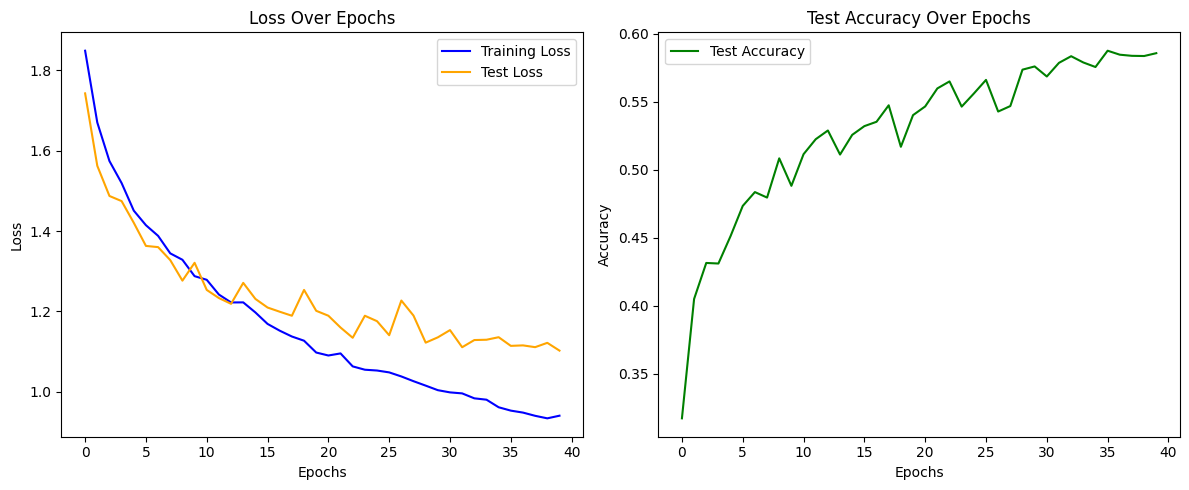

In [9]:
loaded_df4 = pd.read_csv("DE_CNN1_training_metrics.csv")
train_loss4 = loaded_df4["train_loss"].tolist()
test_loss4 = loaded_df4["test_loss"].tolist()
test_accuracy4 = loaded_df4["test_accuracy"].tolist()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss4, label='Training Loss', color='blue')
plt.plot(test_loss4, label='Test Loss', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracy4, label='Test Accuracy', color='green')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(all_targets, all_preds)

np.savetxt(f'confusion_matrix.csv', conf_matrix, delimiter=',', fmt='%d')


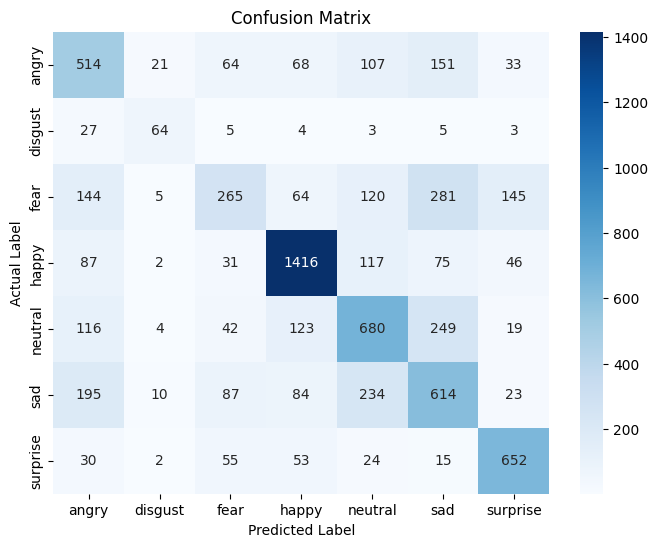

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset2.classes, yticklabels=train_dataset2.classes)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()
